## Mushroom classification project.

The main task of this project is the implementation from scratch of tree predictors for binary classification to determine whether mushrooms are poisonous. 

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import numpy as np
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)

In [78]:
data = pd.read_csv('data/secondary_data.csv', delimiter=';')

num_data_points = data.shape[0]
print(f'The number of data points in the DataFrame: {num_data_points}')

#data.head()

The number of data points in the DataFrame: 61069


### Data exploration

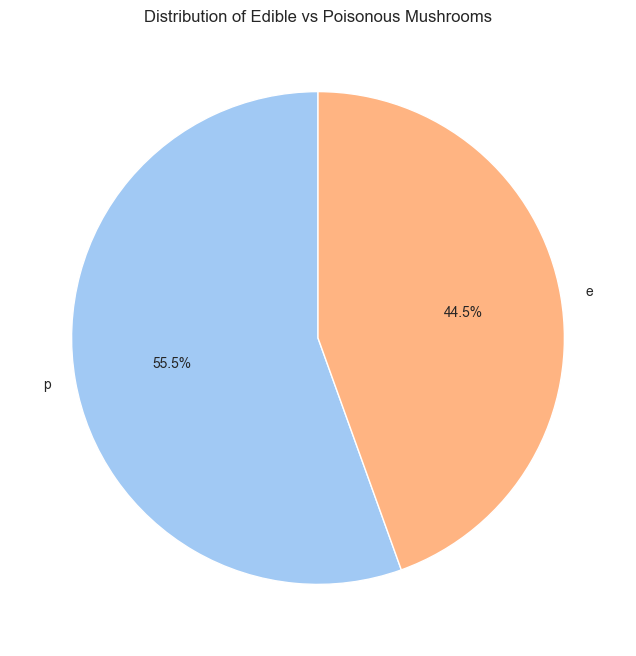

In [79]:
# Distribution of the target column 'class' in the dataset
target_column = 'class'
target_counts = data[target_column].value_counts()
labels = target_counts.index

plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Edible vs Poisonous Mushrooms')
plt.show()

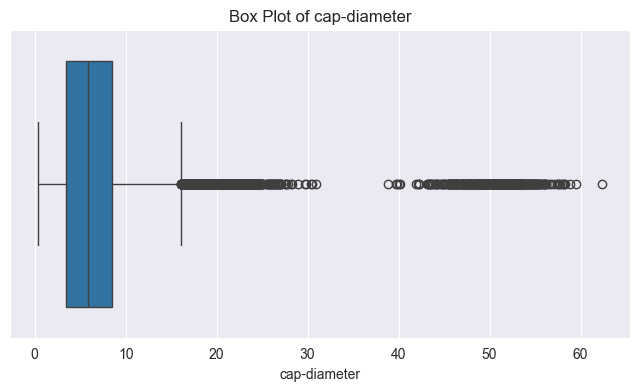

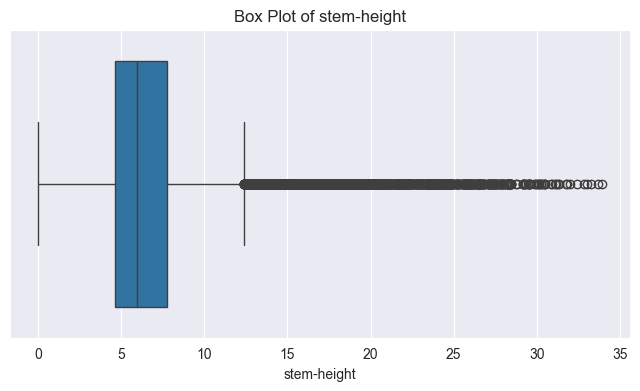

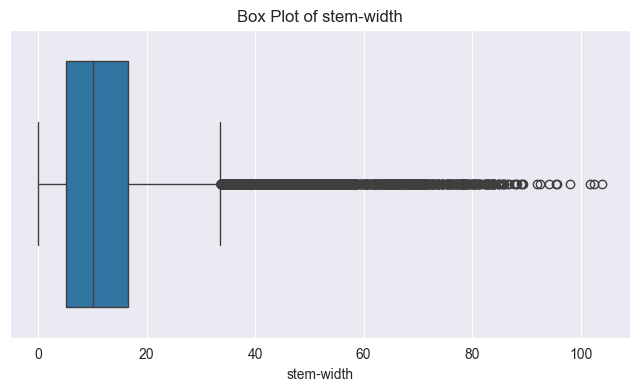

In [80]:
# Distribution for numerical columns
numerical_columns = data.select_dtypes(include=['number']).columns
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')
    plt.show()


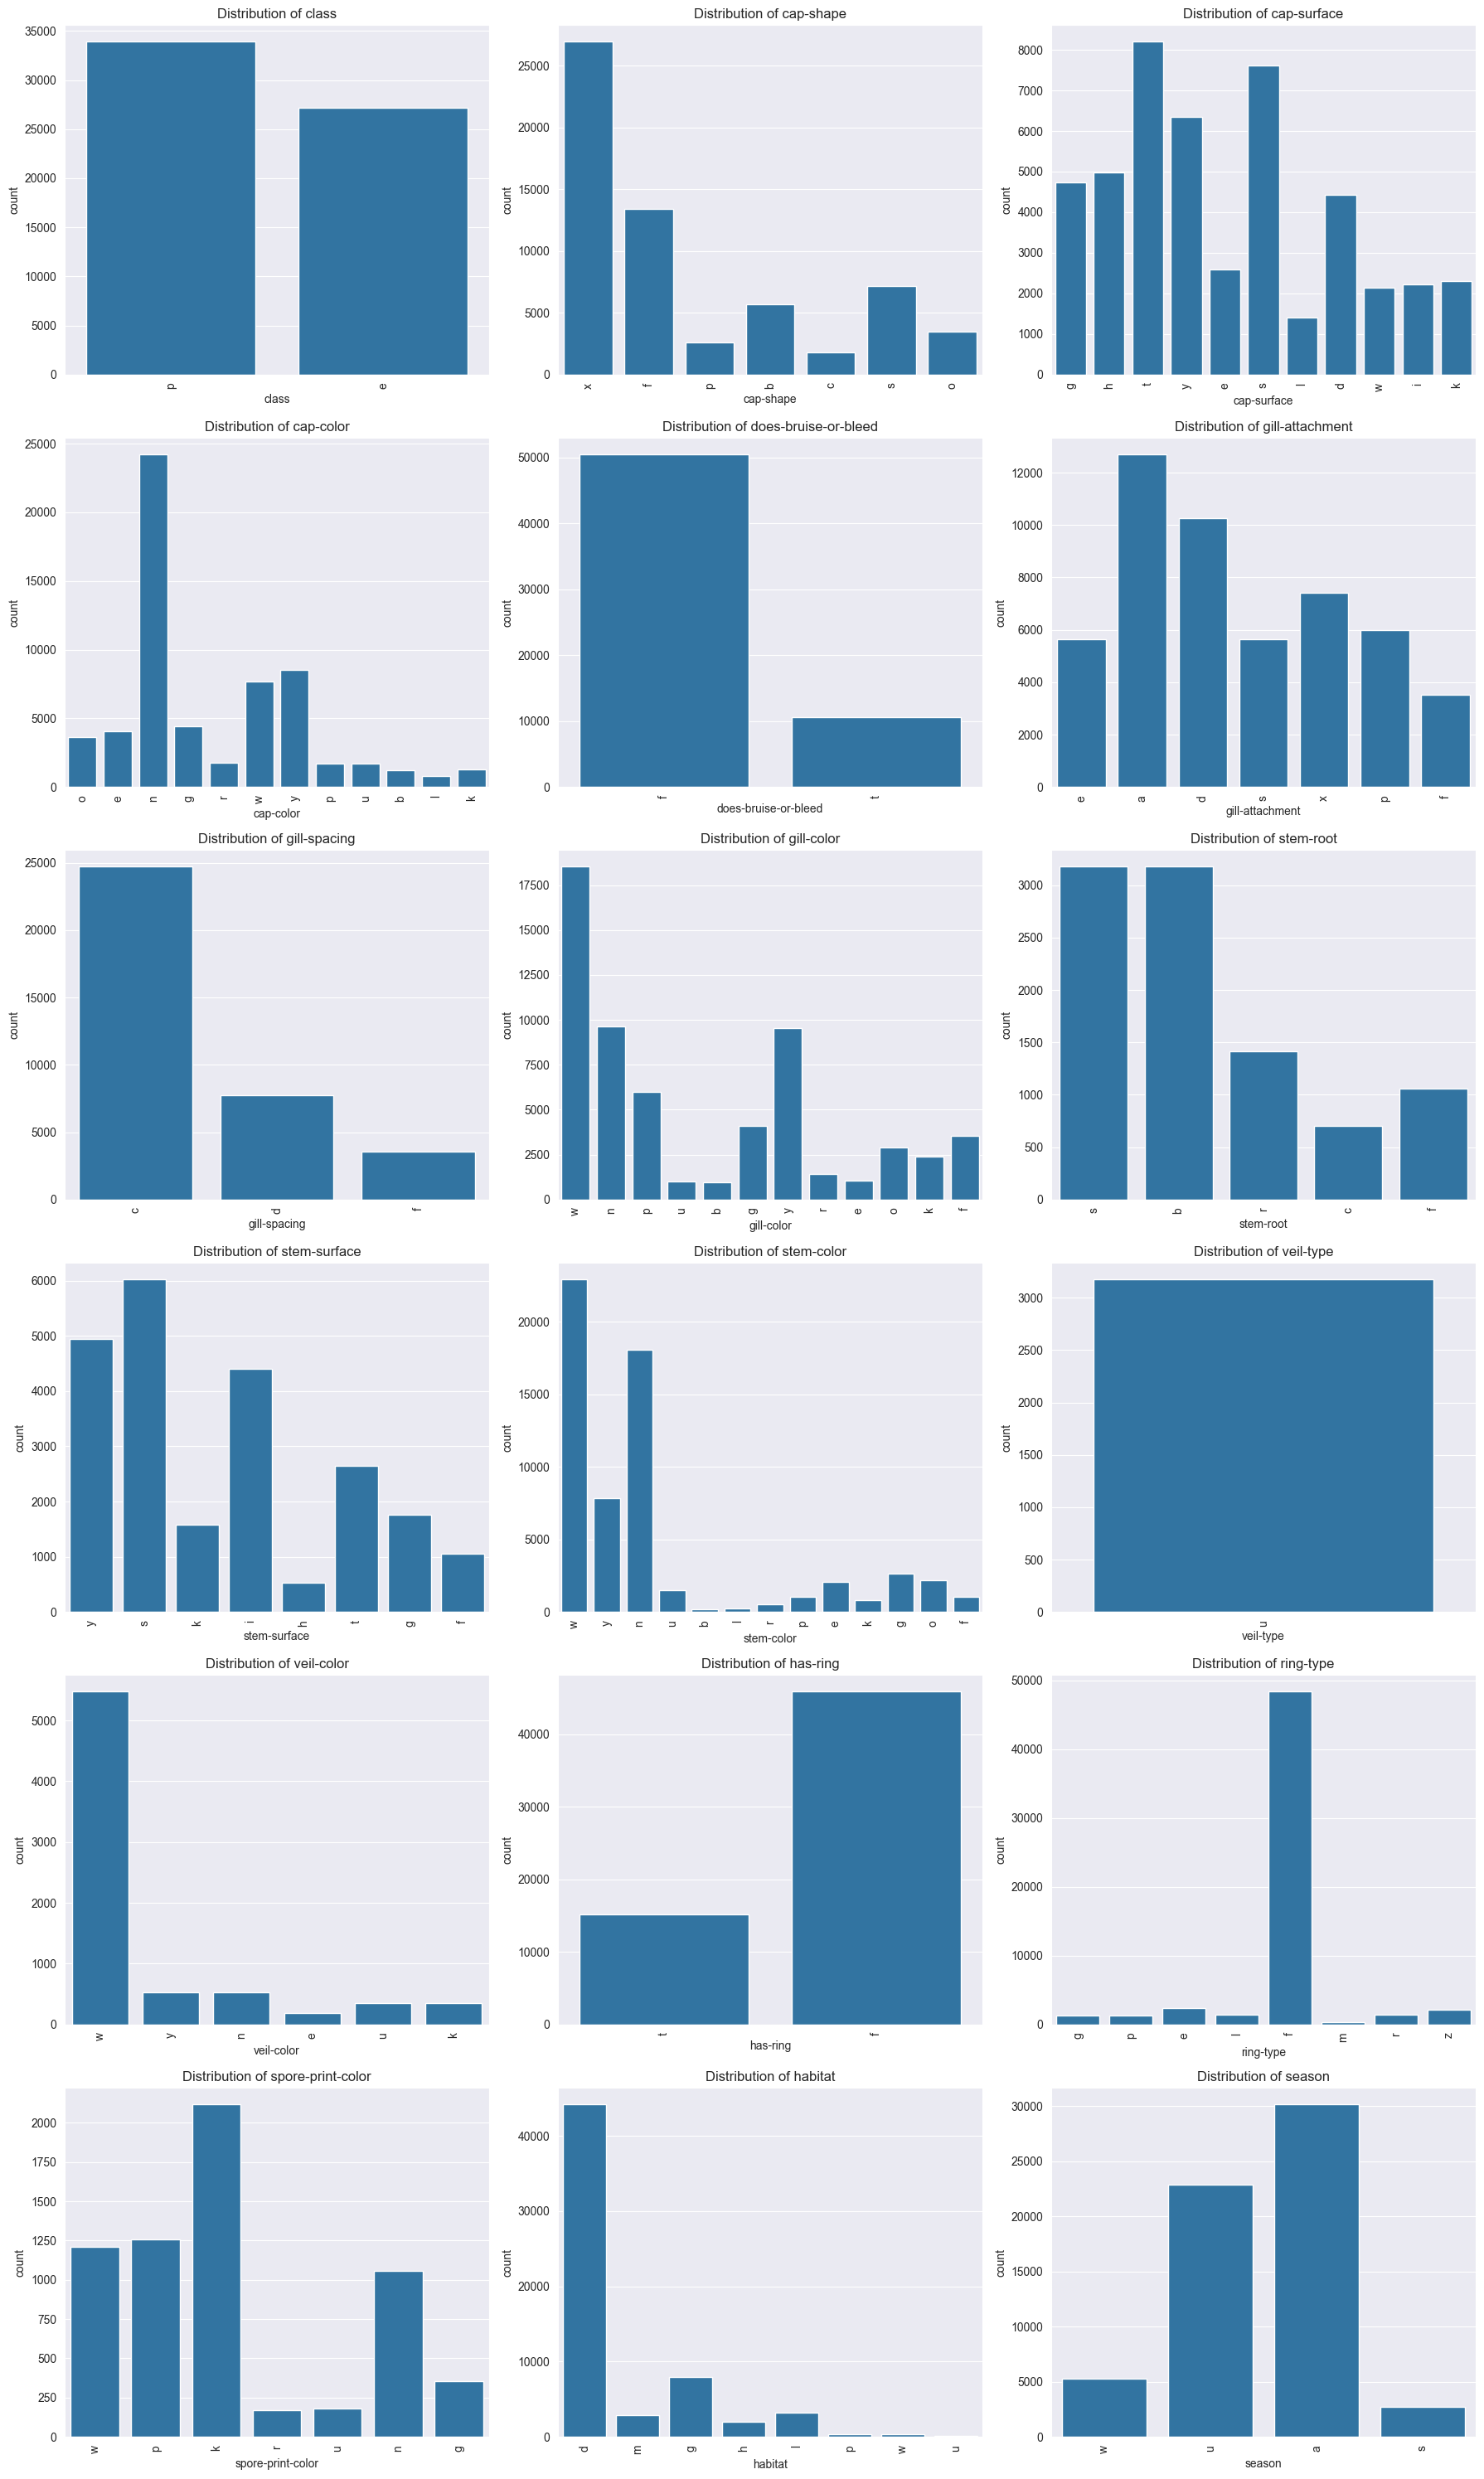

In [81]:
# Distribution for categorical columns
categorical_columns = data.select_dtypes(exclude=['number']).columns

n_cols = 3  
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(x=data[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=90) 

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

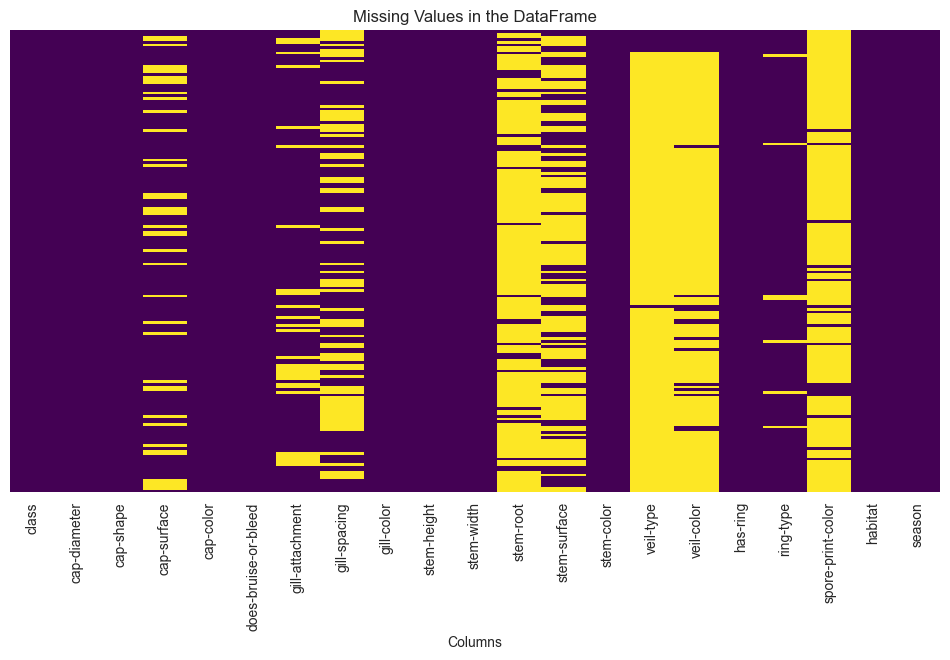

In [82]:
# Plot null values on each column
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.xlabel("Columns")
plt.title("Missing Values in the DataFrame")
plt.show()


### Data cleaning

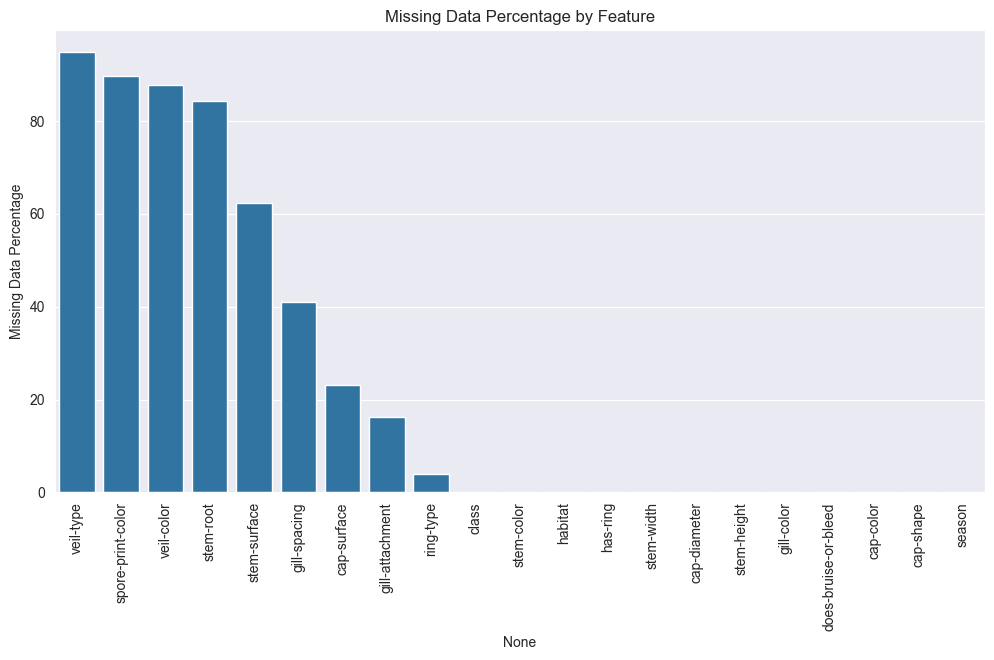

In [83]:
missing_data_percentage = (data.isnull().sum() / data.shape[0]) * 100
missing_data_percentage = missing_data_percentage.sort_values(ascending=False)
#print(missing_data_percentage)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data_percentage.index, y=missing_data_percentage)
plt.xticks(rotation=90)
plt.ylabel('Missing Data Percentage')
plt.title('Missing Data Percentage by Feature')
plt.show()

In [84]:
columns_to_drop = ['veil-type', 'spore-print-color', 'veil-color', 'stem-root', 'stem-surface']
data_cleaned = data.drop(columns=columns_to_drop)
#print(data_cleaned.head())

### Data imputation

In [85]:
columns_to_fill = ['gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']
for column in columns_to_fill:
    most_frequent_value = data_cleaned[column].mode()[0]  # Finding the most frequent value
    data_cleaned[column].fillna(most_frequent_value, inplace=True)

#print(data_cleaned.isnull().sum())

### Data Encoding

In [86]:
non_numeric_columns = data_cleaned.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-color', 'has-ring', 'ring-type', 'habitat', 'season'],
      dtype='object')


In [87]:
print(data_cleaned.info())
print(data_cleaned.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           61069 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       61069 non-null  object 
 7   gill-spacing          61069 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

In [88]:
one_hot_columns = ['cap-shape', 'gill-attachment', 'cap-surface', 'cap-color', 'gill-color', 'stem-color', 'ring-type', 'habitat']
data_encoded = pd.get_dummies(data_cleaned, columns=one_hot_columns)
data_encoded = data_encoded.applymap(lambda x: 1 if x == True else (0 if x == False else x))

label_columns = ['does-bruise-or-bleed', 'gill-spacing', 'class', 'has-ring', 'season']
le = LabelEncoder()
for column in label_columns:
    data_encoded[column] = le.fit_transform(data_encoded[column])
#print(data_encoded.head())

In [89]:
print(data_encoded.select_dtypes(exclude=['number']).columns)

Index([], dtype='object')


### Correlation Matrix of Numerical Features Visualization

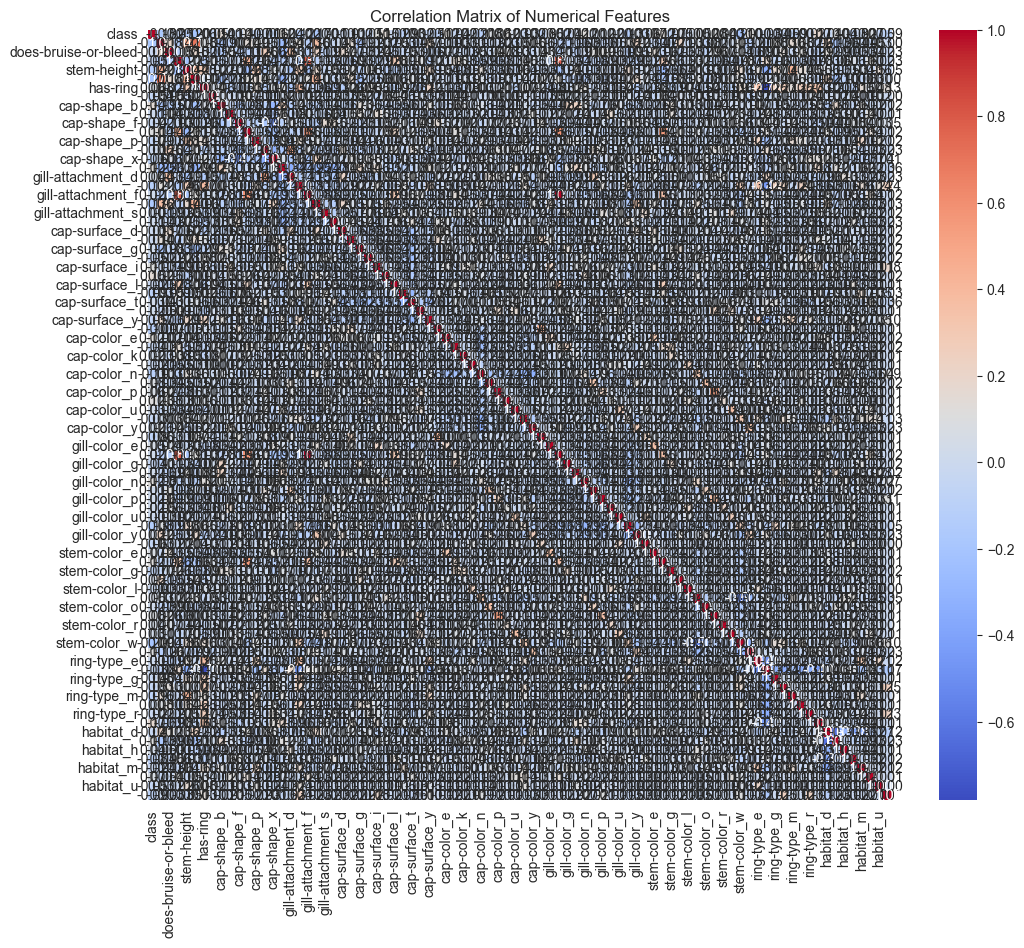

In [90]:
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Correlation Analysis for numerical columns

In [91]:
positive_threshold = 0.5 
negative_threshold = -0.5
weak_threshold = 0.3 

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

strong_positive_corr = upper_triangle[upper_triangle > positive_threshold].stack().reset_index()
strong_positive_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("Strong Positive Correlations:")
print(strong_positive_corr)

strong_negative_corr = upper_triangle[upper_triangle < negative_threshold].stack().reset_index()
strong_negative_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("\nStrong Negative Correlations:")
print(strong_negative_corr)

weak_corr = upper_triangle[(upper_triangle > -weak_threshold) & (upper_triangle < weak_threshold)].stack().reset_index()
weak_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("\nWeak Correlations:")
print(weak_corr)

Strong Positive Correlations:
           Feature 1          Feature 2  Correlation
0       cap-diameter         stem-width     0.695330
1       gill-spacing  gill-attachment_f     0.795385
2       gill-spacing       gill-color_f     0.795385
3        cap-shape_o  gill-attachment_f     0.562095
4        cap-shape_o       gill-color_f     0.562095
5        cap-shape_o       stem-color_f     0.542055
6  gill-attachment_f       gill-color_f     1.000000
7        cap-color_p       stem-color_p     0.524449

Strong Negative Correlations:
      Feature 1     Feature 2  Correlation
0      has-ring   ring-type_f    -0.780288
1  stem-color_n  stem-color_w    -0.502443
2     habitat_d     habitat_g    -0.626131

Weak Correlations:
      Feature 1             Feature 2  Correlation
0         class          cap-diameter    -0.181139
1         class  does-bruise-or-bleed    -0.019889
2         class          gill-spacing    -0.049022
3         class           stem-height    -0.121593
4         class

### Correlation Analysis for class column

In [92]:
class_correlations = correlation_matrix['class'].drop('class') 

strong_positive_corr = class_correlations[class_correlations > positive_threshold].reset_index()
strong_positive_corr.columns = ['Feature', 'Correlation']
print("Strong Positive Correlations with 'class':")
print(strong_positive_corr)

strong_negative_corr = class_correlations[class_correlations < negative_threshold].reset_index()
strong_negative_corr.columns = ['Feature', 'Correlation']
print("\nStrong Negative Correlations with 'class':")
print(strong_negative_corr)

weak_corr = class_correlations[(class_correlations > -weak_threshold) & (class_correlations < weak_threshold)].reset_index()
weak_corr.columns = ['Feature', 'Correlation']
print("\nWeak Correlations with 'class':")
print(weak_corr)

Strong Positive Correlations with 'class':
Empty DataFrame
Columns: [Feature, Correlation]
Index: []

Strong Negative Correlations with 'class':
Empty DataFrame
Columns: [Feature, Correlation]
Index: []

Weak Correlations with 'class':
                 Feature  Correlation
0           cap-diameter    -0.181139
1   does-bruise-or-bleed    -0.019889
2           gill-spacing    -0.049022
3            stem-height    -0.121593
4             stem-width    -0.197368
..                   ...          ...
80             habitat_l    -0.078440
81             habitat_m    -0.019665
82             habitat_p     0.068966
83             habitat_u    -0.048500
84             habitat_w    -0.085139

[85 rows x 2 columns]


In [93]:
### Tree Node Class

In [94]:
class TreeNode:
    def __init__(self, is_leaf=False, decision_criterion=None, prediction=None):
        self.is_leaf = is_leaf
        self.decision_criterion = decision_criterion
        self.left_child = None
        self.right_child = None
        self.prediction = prediction
        self.depth = 0
        self.leaf_count = 0

    def add_children(self, left, right):
        self.left_child = left
        self.right_child = right

### Decision Tree Class with Hyperparameter Tuning 


In [96]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, split_function=None, entropy_threshold=0.0001):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.split_function = split_function
        self.entropy_threshold = entropy_threshold
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_samples < self.min_samples_split or num_labels == 1:
            leaf_value = self._most_common_label(y)
            return TreeNode(is_leaf=True, prediction=leaf_value)

        best_criterion, best_sets = self._best_split(X, y)

        if best_criterion is None:
            leaf_value = self._most_common_label(y)
            return TreeNode(is_leaf=True, prediction=leaf_value)

        left_child = self._grow_tree(best_sets['left_X'], best_sets['left_y'], depth + 1)
        right_child = self._grow_tree(best_sets['right_X'], best_sets['right_y'], depth + 1)

        node = TreeNode(is_leaf=False, decision_criterion=best_criterion)
        node.depth = depth
        node.add_children(left_child, right_child)
        node.leaf_count = 1 if left_child.is_leaf and right_child.is_leaf else 0
        return node

    def _best_split(self, X, y):
        best_criterion = None
        best_sets = None
        best_score = float('inf') if self.split_function in ["gini", "squared_impurity"] else -float('inf')

        num_samples, num_features = X.shape

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)

            for threshold in unique_values:
                left_indices = feature_values <= threshold
                right_indices = ~left_indices

                left_y, right_y = y[left_indices], y[right_indices]

                if len(left_y) == 0 or len(right_y) == 0:
                    continue

                if self.split_function == "gini":
                    score = self._gini_impurity(left_y, right_y)
                elif self.split_function == "entropy":
                    score = self._scaled_entropy(left_y, right_y)
                elif self.split_function == "squared_impurity":
                    score = self._squared_impurity(left_y, right_y)

                if (self.split_function in ["gini", "squared_impurity"] and score < best_score) or (self.split_function == "entropy" and score > best_score):
                    best_score = score
                    best_criterion = (feature_index, threshold)
                    best_sets = {
                        'left_X': X[left_indices], 'right_X': X[right_indices],
                        'left_y': left_y, 'right_y': right_y
                    }

        return best_criterion, best_sets

    def _gini_impurity(self, left_y, right_y):
        n = len(left_y) + len(right_y)
        left_prob = len(left_y) / n
        right_prob = len(right_y) / n

        def gini(y):
            classes, counts = np.unique(y, return_counts=True)
            prob = counts / len(y)
            return 1 - np.sum(prob ** 2)

        gini_left = gini(left_y)
        gini_right = gini(right_y)

        return left_prob * gini_left + right_prob * gini_right

    def _scaled_entropy(self, left_y, right_y):
        n = len(left_y) + len(right_y)
        left_prob = len(left_y) / n
        right_prob = len(right_y) / n

        def entropy(y):
            classes, counts = np.unique(y, return_counts=True)
            prob = counts / len(y)
            return -np.sum(prob * np.log2(prob + 1e-9))

        entropy_left = entropy(left_y)
        entropy_right = entropy(right_y)

        return left_prob * entropy_left + right_prob * entropy_right

    def _squared_impurity(self, left_y, right_y):
        n = len(left_y) + len(right_y)
        left_prob = len(left_y) / n
        right_prob = len(right_y) / n

        def squared_impurity(y):
            classes, counts = np.unique(y, return_counts=True)
            prob = counts / len(y)
            return 1 - np.sum(prob ** 4)

        sq_impurity_left = squared_impurity(left_y)
        sq_impurity_right = squared_impurity(right_y)

        return left_prob * sq_impurity_left + right_prob * sq_impurity_right

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

    def _traverse_tree(self, x, node):
        if node.is_leaf:
            return node.prediction

        feature_index, threshold = node.decision_criterion
        if x[feature_index] <= threshold:
            return self._traverse_tree(x, node.left_child)
        else:
            return self._traverse_tree(x, node.right_child)


### Zero-One Loss Function

In [97]:
def zero_one_loss(y_true, y_pred):
    return np.mean(y_pred != y_true)

### Hyperparameter Tuning

In [98]:
def grid_search(X_train, y_train, param_grid, scoring_func):
    k = 5
    cv = KFold(n_splits=k, shuffle=True, random_state=42)

    def evaluate_params(params):
        current_scores = []

        for train_idxs, val_idxs in cv.split(X_train, y_train):
            X_train_cv, y_train_cv = X_train.iloc[train_idxs], y_train.iloc[train_idxs]
            X_val_cv, y_val_cv = X_train.iloc[val_idxs], y_train.iloc[val_idxs]

            entropy_threshold = params.get('entropy_threshold', 0.0001)

            model = DecisionTree(
                max_depth=params.get('max_depth'),
                split_function=params['split_function'],
                entropy_threshold=entropy_threshold
            )

            model.fit(X_train_cv.values, y_train_cv.values)
            y_val_pred = model.predict(X_val_cv.values)

            score = scoring_func(y_val_cv, y_val_pred)
            current_scores.append(score)

        mean_score = np.mean(current_scores)

        print(f"Zero-one loss: {mean_score:.5f} with params: {params}")

        return params, mean_score

    param_combinations = []

    for params in param_grid:
        split_function = params['split_function']
        if split_function == 'scaled_entropy':
            for depth in params['max_depth']:
                for entropy_threshold in params['entropy_threshold']:
                    param_combinations.append({
                        'max_depth': depth,
                        'split_function': split_function,
                        'entropy_threshold': entropy_threshold
                    })
        else:
            for depth in params['max_depth']:
                param_combinations.append({
                    'max_depth': depth,
                    'split_function': split_function
                })

    print(
        f"\nTotal number of combinations: {len(param_combinations)}  x  {k} cv = {k * len(param_combinations)} iterations\n")

    results = Parallel(n_jobs=-1)(delayed(evaluate_params)(params) for params in param_combinations)

    sorted_results = sorted(results, key=lambda x: x[1])

    print("\nTop 5 Best Results:")
    for rank, (params, mean_score) in enumerate(sorted_results[:5], 1):
        print(f"Rank {rank}: Zero-one loss: {mean_score:.6f} with params: {params}")

    print("\nTop 5 Worst Results:")
    for rank, (params, mean_score) in enumerate(sorted_results[-5:], 1):
        print(f"Rank {rank}: Zero-one loss: {mean_score:.6f} with params: {params}")

    return results, sorted_results[0][0], sorted_results[0][1]


### Evaluation of test results


In [99]:
def evaluate_test_result(test_loss, y_test, y_test_pred, is_grid_search=False):
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test accuracy: {accuracy:.6f}")
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    
    if test_loss < 0.05:
        print("Great result! The model performs very well with a good classification.")
    elif test_loss < 0.1:
        print("Good result! The model's performance is strong, but there may be room for improvement.")
    else:
        if not is_grid_search:
            print(
                "The result is not satisfactory. The model may be underfitting or overfitting. Review the parameters and try again.")
        else:
            print(
                "The result can be improved. The model may be underfitting or overfitting. Consider improving the model.")


## Interactive Flow
### Model Training and Testing


Running grid search for best parameters...

Total number of combinations: 15  x  5 cv = 75 iterations

Zero-one loss: 0.44636 with params: {'max_depth': 20, 'split_function': 'scaled_entropy', 'entropy_threshold': 0.001}
Zero-one loss: 0.44636 with params: {'max_depth': 10, 'split_function': 'scaled_entropy', 'entropy_threshold': 0.001}
Zero-one loss: 0.44636 with params: {'max_depth': 20, 'split_function': 'scaled_entropy', 'entropy_threshold': 0.0001}

Top 5 Best Results:
Rank 1: Zero-one loss: 0.006591 with params: {'max_depth': 20, 'split_function': 'squared_impurity'}
Rank 2: Zero-one loss: 0.006898 with params: {'max_depth': 20, 'split_function': 'gini'}
Rank 3: Zero-one loss: 0.022557 with params: {'max_depth': 15, 'split_function': 'gini'}
Rank 4: Zero-one loss: 0.022843 with params: {'max_depth': 15, 'split_function': 'squared_impurity'}
Rank 5: Zero-one loss: 0.128544 with params: {'max_depth': 10, 'split_function': 'gini'}

Top 5 Worst Results:
Rank 1: Zero-one loss: 0.4463

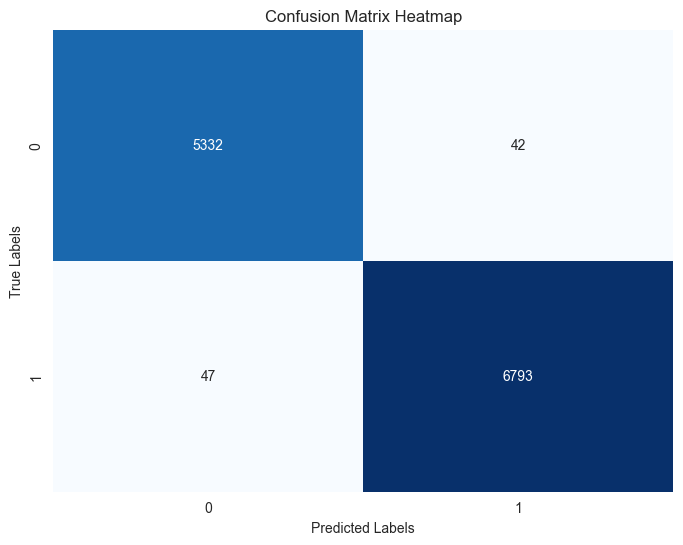

Great result! The model performs very well with a good classification.


In [102]:
    X = data_encoded.drop(['class'], axis=1)
    y = data_encoded['class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = [
        {
            'max_depth': [10, 15, 20],
            'split_function': 'scaled_entropy',
            'entropy_threshold': [0.01, 0.001, 0.0001]
        },
        {
            'max_depth': [10, 15, 20],
            'split_function': 'gini'
        },
        {
            'max_depth': [10, 15, 20],
            'split_function': 'squared_impurity'
        }
    ]

    try:
        user_choice = input("\nWould you like to use the best parameters found by grid search? (yes/no): ").strip().lower()

        if user_choice == 'yes':
            print("\nRunning grid search for best parameters...")
            results, best_params, best_score = grid_search(X_train, y_train, param_grid, scoring_func=zero_one_loss)

            print(f"\nBest parameters: {best_params}")
            print(f"Best score (zero-one loss): {best_score}")

            if best_params['split_function'] == 'scaled_entropy':
                best_tree = DecisionTree(
                    max_depth=best_params['max_depth'],
                    split_function=best_params['split_function'],
                    entropy_threshold=best_params['entropy_threshold']
                )
            else:
                best_tree = DecisionTree(
                    max_depth=best_params['max_depth'],
                    split_function=best_params['split_function']
                )

            best_tree.fit(X_train.values, y_train.values)

            y_test_pred = best_tree.predict(X_test.values)
            test_loss = zero_one_loss(y_test, y_test_pred)
            print(f"Zero-one loss on test set with best params: {test_loss:.6f}")
            evaluate_test_result(test_loss, y_test, y_test_pred, is_grid_search=True)
        elif user_choice == 'no':
            print("\nPlease enter your custom parameters.")
            max_depth = int(input("Enter the max depth for the tree (e.g., 10, 15, 20): "))
            split_function = input("Enter the split function (scaled_entropy/gini/squared_impurity): ").strip()
            if split_function == 'scaled_entropy':
                entropy_threshold = float(input("Enter the entropy threshold (e.g., 0.01, 0.001, 0.0001): "))
            else:
                entropy_threshold = 0.0001

            custom_tree = DecisionTree(
                max_depth=max_depth,
                split_function=split_function,
                min_samples_split=2,
                entropy_threshold=entropy_threshold
            )

            custom_tree.fit(X_train.values, y_train.values)

            y_test_pred = custom_tree.predict(X_test.values)
            test_loss = zero_one_loss(y_test, y_test_pred)
            print(f"Zero-one loss on test set with custom params: {test_loss:.6f}")
            evaluate_test_result(test_loss, y_test, y_test_pred)
        else:
            print("Invalid input. Please run the program again and choose 'yes' or 'no'.")

    except Exception as exc:
        print(f"There was an exception running the program. Exception: {exc}")